#Constants

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
K = 273.15
G = 6.674e-11
gamma = 0.3
S_0 = 917
sigma = 5.670367e-8
timestep = 1
R = 0.5
albedo_w = 0.75
albedo_b = 0.25
albedo_g = 0.5
T_min = 278.15
T_max = 313.15
solar_constant = 970

#Helper functions

In [9]:
def solar_declination(time): 
    gamma = 2 * math.pi * ((time%365) - 1)/365
    return (0.006918
            - 0.399912*math.cos(gamma) + 0.070257*math.sin(gamma)
            - 0.006758*math.cos(2*gamma) + 0.000907*math.sin(2*gamma)
            - 0.002697*math.cos(3*gamma) + 0.001480*math.sin(3*gamma))

def eccentricity_corrector(time):
    return 1 + 0.033 * math.cos(2*math.pi * (time%365)/365)

def hour_angle_sunset(latitude, delta):
    # latitude and delta in radians
    cos_omega_s = -math.tan(latitude) * math.tan(delta)
    cos_omega_s = max(-1.0, min(1.0, cos_omega_s))
    return math.acos(cos_omega_s)

def daily_radiation(time, latitude):
    latitude = math.radians(latitude)
    E_0 = eccentricity_corrector(time)
    delta = solar_declination(time)
    omega_s = hour_angle_sunset(latitude, delta)
    # Daily mean insolation (zero at night)
    I_0 = (solar_constant / math.pi) * E_0 * (
        omega_s * math.sin(latitude) * math.sin(delta) +
        math.cos(latitude) * math.cos(delta) * math.sin(omega_s)
    )
    # Clamp to zero if sun never rises
    return max(I_0, 0)

def area_fraction(latitude):
   latitude = math.radians(latitude)
   return abs((math.sin(latitude + 1/180 * math.pi) - math.sin(latitude))/2)

#Initial Conditions & Main Code

In [16]:
T_p_seq = []
A_w_seq = []
A_b_seq = []
A_w = np.ones(180) * 0.8
A_b = np.ones(180) * 0.2
T_p = 20 + K
albedo_p = np.zeros(180)
areas = np.vectorize(area_fraction)(np.arange(0, 180))

for time in range(365*100):
    delta_A_b = np.zeros(180)
    delta_A_w = np.zeros(180)
    T = np.zeros(180)
    for lat in range(0, 180):
        x = np.ones(180) - A_w - A_b
        albedo_p[lat] = A_w[lat] * albedo_w + x[lat] * albedo_g + A_b[lat] * albedo_b
        I_0 = daily_radiation(time, lat)  # <-- use daily radiation
        area_i = areas[lat]
        T[lat] = (I_0 * (1 - albedo_p[lat])/sigma)**0.25
        # print(albedo_p, T_p_i, I_0)
        T_w = ((R * I_0 / sigma * (albedo_p[lat] - albedo_w)) + T[lat] ** 4) ** 0.25
        T_b = ((R * I_0 / sigma * (albedo_p[lat] - albedo_b)) + T[lat] ** 4) ** 0.25
        if T_b <= T_max and T_b >= T_min:
            beta_b = 1 - 0.003265 * (295.65 - T_b) ** 2
        else:
            beta_b = 0
        if T_w <= T_max and T_w >= T_min:
            beta_w = 1 - 0.003265 * (295.65 - T_w)**2
        else:
            beta_w = 0
        delta_A_w[lat] += area_i * A_w[lat] * (x[lat] * beta_w - gamma) * 1  # timestep = 1 day
        delta_A_b[lat] += area_i * A_b[lat] * (x[lat] * beta_b - gamma) * 1
    T_p_new = np.dot(T, areas)
    T_p = np.ones(180) * T_p_new
    A_w += delta_A_w
    A_w_seq.append(np.mean(A_w))
    A_b += delta_A_b
    A_b_seq.append(np.mean(A_b))
    T_p_seq.append(T_p_new)

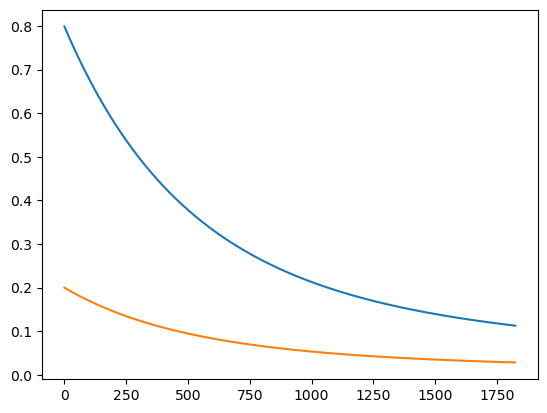

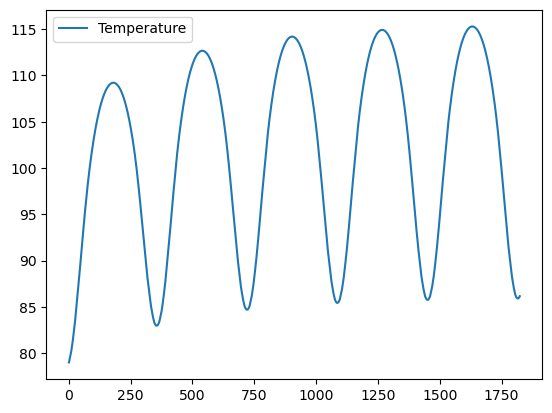

In [15]:
plt.plot(A_w_seq, label = 'White')
plt.plot(A_b_seq, label = 'Black')
plt.show()
plt.plot(T_p_seq, label = 'Temperature')
plt.legend()
plt.show()